In [8]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import quantstats as qs
import copy
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions
from datetime import datetime, timedelta
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import CLA, plotting
from pypfopt import hierarchical_portfolio
from pypfopt import plotting
from metrics import *


DATA_DIR = (os.getcwd() + "/data/")
PREDICTION_DIR = (os.getcwd() + "/predictions_new/")
start_date = '2014-01-01'
end_date = "2019-11-30"
# Get fundamental data for each stock in the ticker and append to the dataframe


def get_all_symbols():
    return [v.strip('.csv') for v in os.listdir(DATA_DIR)]


def get_current_predictions():
    return [v.strip('_predictions.csv') for v in os.listdir(PREDICTION_DIR)]


tickers = get_all_symbols()
predicted_tickers = get_current_predictions()

sample_index = pd.read_csv(DATA_DIR + 'AAPL.csv',
                           index_col='Date', parse_dates=True)
mask = (sample_index.index >= start_date) & (sample_index.index <= end_date)
sample_index = sample_index.loc[mask]


In [18]:
def get_top_n_tickers(year, month, n):
    # print("Getting top n tickers for year: " + str(year) + " month: " + str(month))
    results = []
    for ticker in get_current_predictions():
        df = pd.read_csv(PREDICTION_DIR + ticker +
                         '_predictions.csv', index_col='Date', parse_dates=True)
        mask = (df.index.year == year) & (df.index.month == month)
        df = df.loc[mask]
        # print(ticker, df['Next Month Returns Predictions'][0])
        results.append((ticker, df['Next Month Returns Predictions'][0]))

    # print(results)
    results.sort(key=lambda x: x[1], reverse=True)
    tickers = [i[0] for i in results[:n]]
    pred_vector = [i[1] for i in results[:n]]
    # print(pred_vector)
    # print(year, month)
    return tickers, pred_vector


def get_close_prices(year, month, d, tickers):
    df = pd.DataFrame()
    days = d * 365
    target_date = datetime(year, month, 1) - timedelta(days=days)
    for ticker in tickers:
        data = pd.read_csv(DATA_DIR + ticker + '.csv',
                           index_col='Date', parse_dates=True)
        mask = (data.index >= target_date) & (
            data.index <= datetime(year, month, 1))
        data = data.loc[mask]
        df[ticker] = data['Close']
        df.index = data.index

    return df


def generate_predicted_historical_returns(year, month, d, tickers):
    d = d * 365
    target_date = datetime(year, month, 1) - timedelta(days=d)
    df = pd.DataFrame()
    for ticker in tickers:
        prediction = pd.read_csv(
            PREDICTION_DIR + ticker + '_predictions.csv', index_col='Date', parse_dates=True)
        mask = (prediction.index >= target_date) & (
            prediction.index <= datetime(year, month, 1))
        prediction = prediction.loc[mask]
        df[ticker] = prediction['Next Month Returns Predictions']
        df.index = prediction.index
    return df


def get_top_n_tickers_combined(start_year, start_month, end_year, end_month, n):
    output = []
    pred_vectors = []
    curr_year, curr_month = start_year, start_month
    while not (curr_year > end_year or (curr_year == end_year and curr_month > end_month)):
        tickers, pred_vector = get_top_n_tickers(curr_year, curr_month, n)
        output.append(tickers)
        pred_vectors.append(pred_vector)

        if curr_month == 12:
            curr_month = 1
            curr_year += 1
        else:
            curr_month += 1
    return output, pred_vectors


def generate_close_data(tickers, month, year):
    df = pd.DataFrame()
    for ticker in tickers:
        data = pd.read_csv(DATA_DIR + ticker + '.csv',
                           index_col='Date', parse_dates=True)
        data = data.loc[data.index.month == month]
        data = data.loc[data.index.year == year]
        df[ticker] = data['Close']
        df.index = data.index
    return df


def generate_all_close_data(tickers, start_year, start_month, end_year, end_month):
    output = pd.DataFrame()
    curr_year, curr_month = start_year, start_month
    curr_idx = 0
    while not (curr_year > end_year or (curr_year == end_year and curr_month > end_month)):
        data = generate_close_data(tickers[curr_idx], curr_month, curr_year)
        output = pd.concat([output, data], axis=0, join='outer')
        output = output.reset_index(drop=True)
        if curr_month == 12:
            curr_month = 1
            curr_year += 1
        else:
            curr_month += 1
        curr_idx += 1

    output.index = sample_index.index
    return output


In [23]:
def generate_hrp_models(start_month, start_year, end_month, end_year, d, n):

    curr_year, curr_month = start_year, start_month
    dfs = {
        "d": [],
        "dfs": []
    }
    curr_max = 0
    curr_model = None
    for d in range(1, 4):
        df = {
            'sharpes': [],
            'expected_return': [],
            'annual_volatility': [],
            'num_stocks': [],
            'weights': []
        }
    # while not (curr_year > end_year or (curr_year == end_year and curr_month > end_month)):
        for i in range(25, 275, 25):
            tickers, pred_vector = get_top_n_tickers(curr_year, curr_month, i)
            close_data = get_close_prices(curr_year, curr_month, d, tickers)
            predicted_returns = generate_predicted_historical_returns(
                curr_year, curr_month, d, tickers)
            rets_old = expected_returns.returns_from_prices(close_data)
        
            rets = pd.DataFrame(predicted_returns)
            print(rets)
            print(rets_old)
            hrp = hierarchical_portfolio.HRPOpt(rets)
            # hrp.add_objective(objective_functions.L2_reg, gamma=0.1)
            raw_weights = hrp.optimize()
            cleaned_weights = hrp.clean_weights()
            hrp.portfolio_performance(verbose=False)

            ex_return = hrp.portfolio_performance()[0]
            df['expected_return'].append(ex_return)
            df['num_stocks'].append(i)
            df['annual_volatility'].append(hrp.portfolio_performance()[1])
            df['sharpes'].append(hrp.portfolio_performance()[2])
            df['weights'].append(cleaned_weights)
            
            if hrp.portfolio_performance()[2] > curr_max:
                curr_max = hrp.portfolio_performance()[2]
                curr_model = hrp
        # print(ef.portfolio_performance()[0]) # sharpe ratio
        dfs["d"].append(d)
        dfs['dfs'].append(df)

    # Plot Graph
    # plt.plot(df['num_stocks'], df['sharpes'])
    # print(dfs)
    return dfs, curr_model


In [24]:
results, best_model = generate_hrp_models(1, 2014, 11, 2019, 1, 25)

                 WAT      HSIC       APA       ECL       AOS      FAST  \
Date                                                                     
2013-12-31  0.024731  0.015478  0.050124  0.066685  0.114943  0.056385   

                   C       RCL       URI       PNR  ...       SWK       SHW  \
Date                                                ...                       
2013-12-31  0.004006  0.038055  0.061744  0.003928  ... -0.060758  0.011119   

                 MCK       EFX       NEE       VMC       RJF      IDXX  \
Date                                                                     
2013-12-31 -0.041187 -0.001855  0.031548  0.054268  0.166679  0.008656   

                 VFC      CSGP  
Date                            
2013-12-31 -0.063066  0.159506  

[1 rows x 25 columns]
                 WAT      HSIC       APA       ECL       AOS      FAST  \
Date                                                                     
2013-01-03 -0.028069  0.000364  0.013376 -0.00

C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:10474: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\yinki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


ValueError: The condensed distance matrix must contain only finite values.

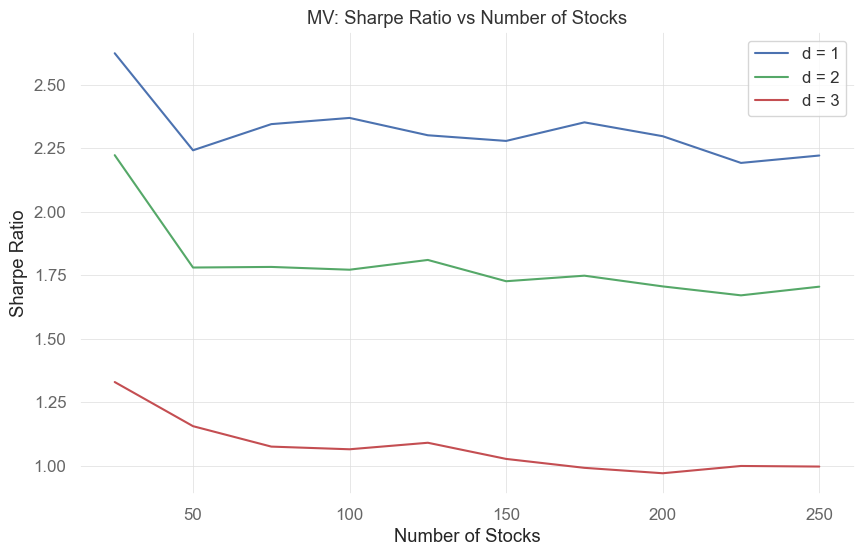

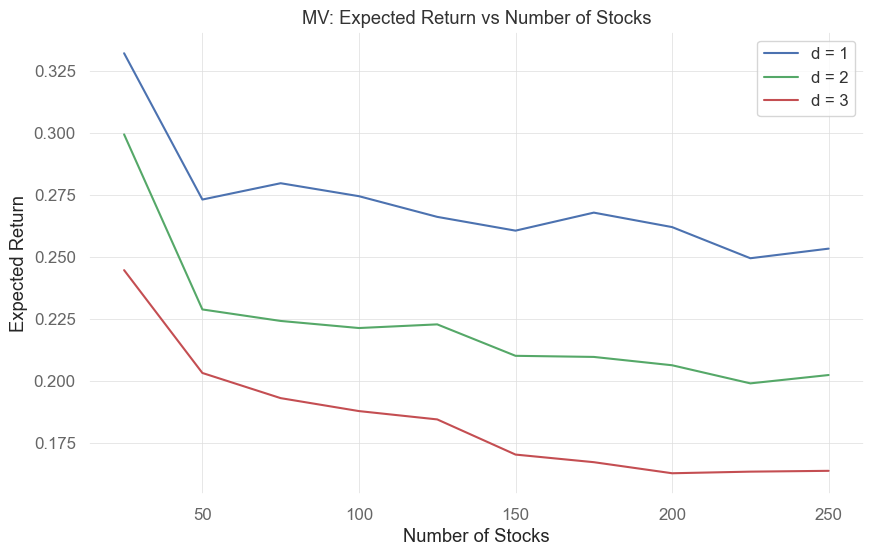

In [39]:
# Plot Graph results
# print(results)
# Make plot grid 2x2
# fig, axs = plt.subplots(2, 2, figsize=(10, 10))
d = [1, 2, 3]
for i, result in enumerate(results['dfs']):
    # print(i, result)
    plt.plot(result['num_stocks'], result['sharpes'])
    plt.xlabel('Number of Stocks')
    plt.ylabel('Sharpe Ratio')
    # plt.legend(['d = ' + str(d[i])])
    plt.title('MV: Sharpe Ratio vs Number of Stocks')
plt.legend(['d = 1', 'd = 2', 'd = 3'])
plt.show()

for i, result in enumerate(results['dfs']):
    # print(i, result)
    plt.plot(result['num_stocks'], result['expected_return'])
    plt.xlabel('Number of Stocks')
    plt.ylabel('Expected Return')
    # plt.legend(['d = ' + str(d[i])])
    plt.title('MV: Expected Return vs Number of Stocks')
plt.legend(['d = 1', 'd = 2', 'd = 3'])
plt.show()


Expected annual return: 33.2%
Annual volatility: 11.9%
Sharpe Ratio: 2.62
Performance of best portfolio: (0.3319550055725878, 0.11884792050573212, 2.6248251062797685)
Best Portfolio Weights: OrderedDict([('WAT', 0.02962), ('HSIC', 0.07772), ('APA', 0.05332), ('ECL', 0.0614), ('AOS', 0.02075), ('FAST', 0.03876), ('C', 0.02997), ('RCL', 0.0326), ('URI', 0.0091), ('PNR', 0.0262), ('BBY', 0.01478), ('FCX', 0.01886), ('GILD', 0.01526), ('TSN', 0.05379), ('VLO', 0.02035), ('SWK', 0.04948), ('SHW', 0.02522), ('MCK', 0.06726), ('EFX', 0.05786), ('NEE', 0.10065), ('VMC', 0.01213), ('RJF', 0.0196), ('IDXX', 0.06347), ('VFC', 0.0688), ('CSGP', 0.03306)])


<AxesSubplot: >

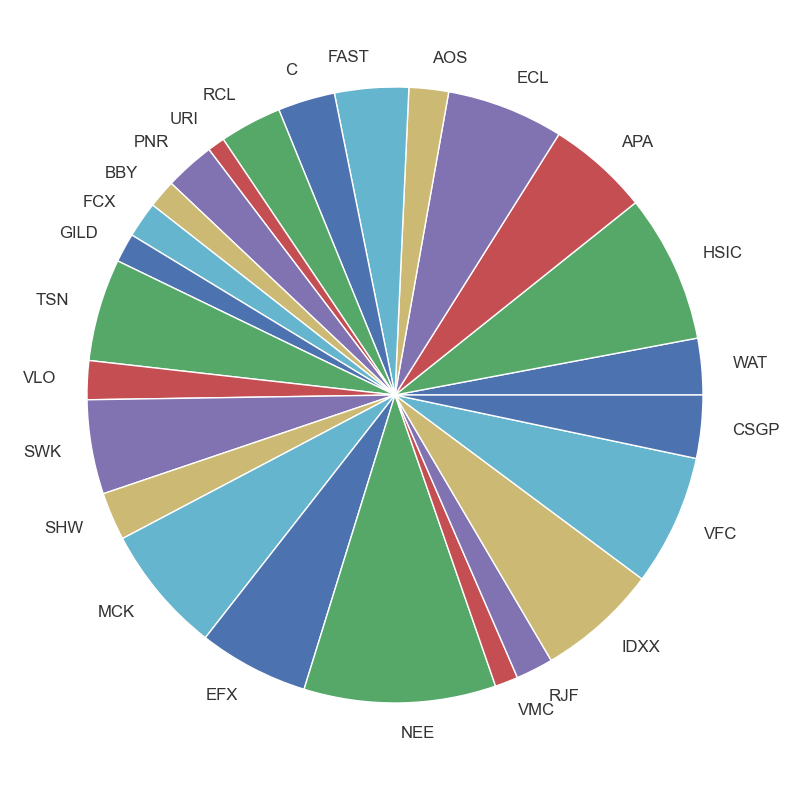

In [40]:
# Get best Portfolio based on sharpe ratio
# print(results)
print(f"Performance of best portfolio: {best_model.portfolio_performance(verbose=True)}")
print(f"Best Portfolio Weights: {best_model.clean_weights()}")

# Plotting
pd.Series(best_model.clean_weights()).plot.pie(figsize=(10, 10))

